In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path, PosixPath
from PIL import Image
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from tqdm import tqdm

/home/guests/tuna_gurbuz/prototype


Multiview Point Cloud Registration

In [3]:
samples = {
    'hammer': {
        0: PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-004777.jpg'),
       1: PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-004777.jpg'),
       2: PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-004777.jpg'),
   },
    
}

In [4]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

def load_depth(image_paths):
    last_part = str(image_paths.parts[-1].split('/')[-1].replace('.jpg', '.tiff').replace('color', 'depth'))
    depth_path = image_paths.parents[1] / 'depthimage' / last_part
    # Load depth image
    gt_depth_image = Image.open(depth_path)
    # Resize depth image to 512x512
    return gt_depth_image  

In [5]:
mv_images = []
mv_depth_images = []
image_size = (512, 384)

for i in range(3):
    img_path = samples['hammer'][i]
    img = load_image(img_path)
    gt_depth_image = load_depth(img_path)

    img = img.resize(image_size, Image.BILINEAR)
    gt_depth_image = gt_depth_image.resize(image_size)

    mv_images.append(ToTensor()(img))
    mv_depth_images.append(ToTensor()(gt_depth_image))

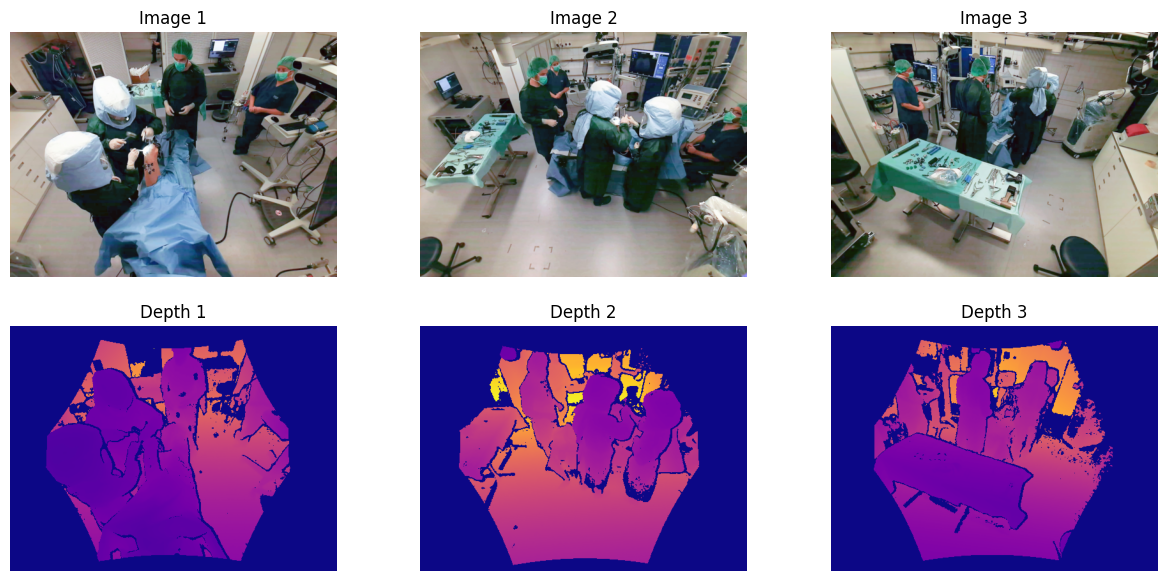

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
for i, im in enumerate(mv_images):
    axs[0, i].imshow(im.permute(1, 2, 0))  # Change to HxWxC for plotting
    axs[0, i].set_title(f'Image {i+1}')
    axs[0, i].axis('off')

    axs[1, i].imshow(mv_depth_images[i].squeeze(), cmap='plasma')  # Change to HxW for plotting
    axs[1, i].set_title(f'Depth {i+1}')
    axs[1, i].axis('off')

In [11]:
sys.path.append(f'{project_dir}/models/PromptDA')
from promptda.promptda import PromptDA
import cv2

DEVICE = 'cuda'
# model = PromptDA.from_pretrained("/home/guests/tuna_gurbuz/prototype/models/PromptDA/promptda/checkpoints/model.ckpt").to(DEVICE).eval()
model = PromptDA.from_pretrained('depth-anything/prompt-depth-anything-vitl').to(DEVICE).eval()

/home/guests/tuna_gurbuz/miniforge3/envs/promptDAnev/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


[INFO] Loading checkpoint from /home/guests/tuna_gurbuz/.cache/huggingface/hub/models--depth-anything--prompt-depth-anything-vitl/snapshots/573ab70c94c27d96f0bc70f81f670d2b0a62d571/model.ckpt


In [12]:
def ensure_multiple_of(x, m=14, round_fn=np.floor):
    """
    Round *x* to the nearest *lower* multiple of *m* by default.
    Switch to np.ceil if you prefer rounding up (keep <= max_size in mind).
    """
    return int(round_fn(x / m) * m)

def pre_process(image, max_size=1008, multiple_of=14, round_fn=np.floor):
    h, w = image.shape[:2]

    # snap both dims to a multiple of 14, *without* exceeding original size
    tar_h = ensure_multiple_of(h, multiple_of, round_fn)
    tar_w = ensure_multiple_of(w, multiple_of, round_fn)

    # If we rounded down to 0 (rare for tiny crops) keep at least one multiple
    tar_h = max(tar_h, multiple_of)
    tar_w = max(tar_w, multiple_of)

    # resize if we changed anything *or* we still exceed max_size
    if (tar_h != h or tar_w != w) or max(tar_h, tar_w) > max_size:
        # uniform scaling factor (≤ 1) so longer edge ≤ max_size
        scale = min(1.0, max_size / max(tar_h, tar_w))
        tar_h = ensure_multiple_of(tar_h * scale, multiple_of, round_fn)
        tar_w = ensure_multiple_of(tar_w * scale, multiple_of, round_fn)
        image = cv2.resize(image, (tar_w, tar_h), interpolation=cv2.INTER_AREA)

    return image

image_to_test = mv_images[0]
gt_depth_to_test = mv_depth_images[0] / 1000.0  # Convert to meters

if len(image_to_test.shape) == 3:
    image_to_test = image_to_test.unsqueeze(0)  # Add batch dimension
if len(gt_depth_to_test.shape) == 3:
    gt_depth_to_test = gt_depth_to_test.unsqueeze(0)  # Add batch dimension
if image_to_test.device != DEVICE:
    image_to_test = image_to_test.to(DEVICE)
if gt_depth_to_test.device != DEVICE:
    gt_depth_to_test = gt_depth_to_test.to(DEVICE)

resize_to_factor_14 = Resize((378, 504))
image_to_test = resize_to_factor_14(image_to_test)
gt_depth_to_test = resize_to_factor_14(gt_depth_to_test)

# image_to_test = pre_process(image_to_test)
# gt_depth_to_test = pre_process(gt_depth_to_test)

In [13]:
image_to_test.shape, gt_depth_to_test.shape, image_to_test.dtype, gt_depth_to_test.dtype

(torch.Size([1, 3, 378, 504]),
 torch.Size([1, 1, 378, 504]),
 torch.float32,
 torch.float32)

In [14]:
depth = model.predict(image_to_test, gt_depth_to_test) # HxW, depth in meters

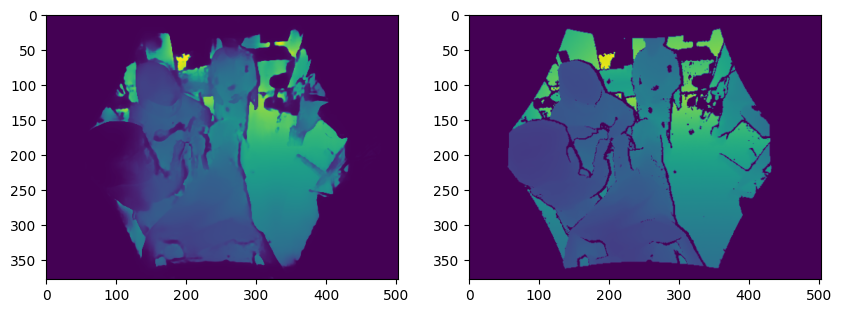

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(depth[0,0].cpu().numpy())
ax[1].imshow(gt_depth_to_test[0,0].cpu().numpy())

In [ ]:
_flag_dump = False
if _flag_dump:
    with open('../temp/mv_img_views.npy', 'wb') as f:
        np.save(f, np.array(img_views))
    with open('../temp/mv_depth_views.npy', 'wb') as f:
        np.save(f, np.array(depth_views))
    with open('../temp/camera_int.npy', 'wb') as f:
        np.save(f, np.array(cam_int))
    with open('../temp/camera_ext.npy', 'wb') as f:
        np.save(f, np.array(cam_ext))

Remove Black Padding

In [ ]:
import open3d as o3d

cam_imgs = np.array(img_views)
depth_imgs = np.array(depth_views)
camera_ext = np.array(cam_ext)
camera_int = np.array(cam_int)

In [ ]:
H,W = depth_imgs.shape[-2:]
buffer = (W-H) // 2
cam_imgs = cam_imgs[:,:,:, buffer:-buffer, :]
assert cam_imgs.shape[-2:] == depth_imgs.shape[-2:]

Remove Padding in Intrinsics

In [ ]:
camera_int[:, 1, 2] = camera_int[:, 1, 2] - buffer

In [ ]:
pcds = []
num_images = cam_imgs.shape[0]
num_images = 1

for idx in range(num_images):
  for view_idx in range(3):
    # Get images
    rgb = (cam_imgs[idx, view_idx].transpose(1,2,0) * 256).astype(np.uint8)
    rgb = np.ascontiguousarray(rgb)
    d_tmp = depth_imgs[idx, view_idx]
    rgb = o3d.geometry.Image(rgb)
    d = o3d.geometry.Image(d_tmp)
    # Get extrinsics
    extrinsics = camera_ext[view_idx]
    # Get intrinsics
    intrinsics = camera_int[view_idx]
    intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(width=W, height=H, fx=intrinsics[0, 0], fy=intrinsics[1, 1], cx=intrinsics[0, 2], cy=intrinsics[1, 2])
    # Compute RGBD
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, d, convert_rgb_to_intensity=False, depth_scale=1, depth_trunc=10000000)
    # Create PC
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic_o3d)
    pcd.points = o3d.utility.Vector3dVector(np.asarray(pcd.points) / 1000)
    # Rotate
    pcd.transform(extrinsics)
    pcds.append(pcd)

In [ ]:
for i, pcd in enumerate(pcds):
    o3d.io.write_point_cloud(f"point_cloud_{i}.pcd", pcd)